# Working with SAS using Python

This notebook demonstrates how to connect to **SAS** online **academic edition** using personal email address and password through **python**.

## Why would i like to do so

There could be multiple reasons to do so. But from my personal experience configuring python to do enterprise level analysis is very very time consuming. Also, since python benefits from being open source, it is usually very difficult beast to tame. In my opinion, python greatest strength in enterprise settings is data ingestion. To have reliable and non-fuss analysis, SAS plays an important role as very little or no configuration is needed to actually produce the result.
Also, it was a challenge for me. Although there was official documentation available around SASPy, there were so many tweeks that were needed to make the SASPy work.

## Steps to achieve connectivity

### 1. Creating SAS ODA Account

Creating SAS account on OnDemand for Academics (ODA) is very easy and costs nothing. You get to access free sample SAS datasets and practice a lot of SAS PROCs. Do it at [https://www.sas.com/en_us/software/on-demand-for-academics.html]

### 2. Creating a Python Environment

Good idea is to create a seperate new Python environment. My preferred way is to use **venv** package in python using command prompt.

#### Some *venv* useful commands with reference to my environment

Easiest way to manage a python environment in **venv** is to create folder in Windows. My Folder name is *ds-env*. *The screenshot below shows the folder structure **after** I had created the environment. If you are creating the environment afresh, it will be empty.*

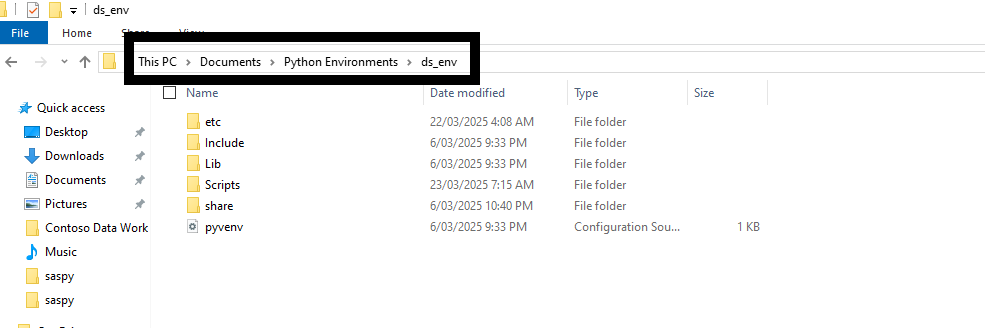

Next step is to actually create the virtual environment. I created the virtual environment using the following command in **command prompt**. Note that I have commented the directory path in double quotes

**python -m venv "C:\Users\Faisal Iqbal\Documents\Python Environments\ds_env"**

Once the environment is created, I can access the python environment by running the **activate** command.

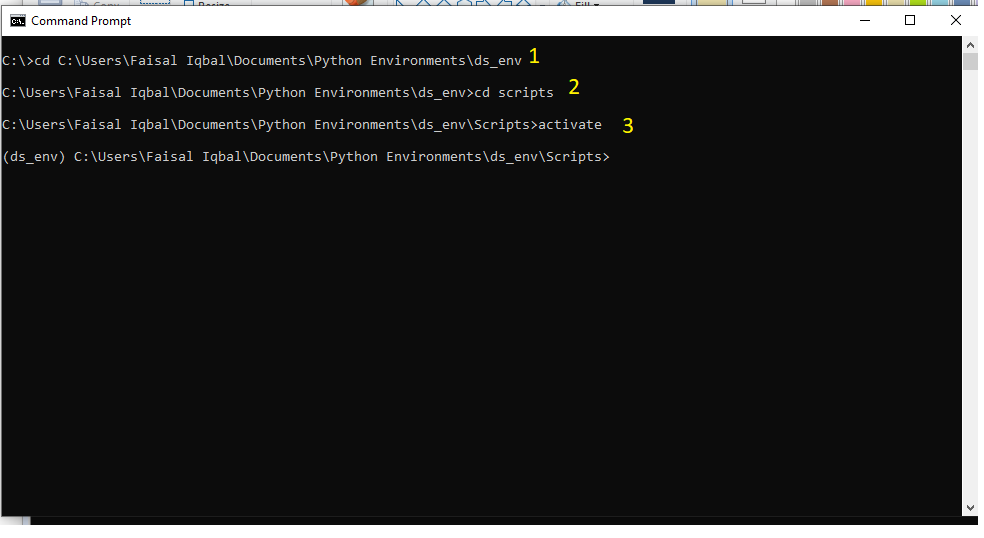

Once environment is activated, the environment name appaers in brackets on the left at the start of the command. Next step is to install packages.

### 3. Installing the packages

I used the **pip install** command to install the following packages

1. saspy
2. sas_kernel

### 4. Installing Java Runtime time environment

Self explanatory, I had to install Java run time environment. For configuration purposes, I note the path where **java.exe** was located.

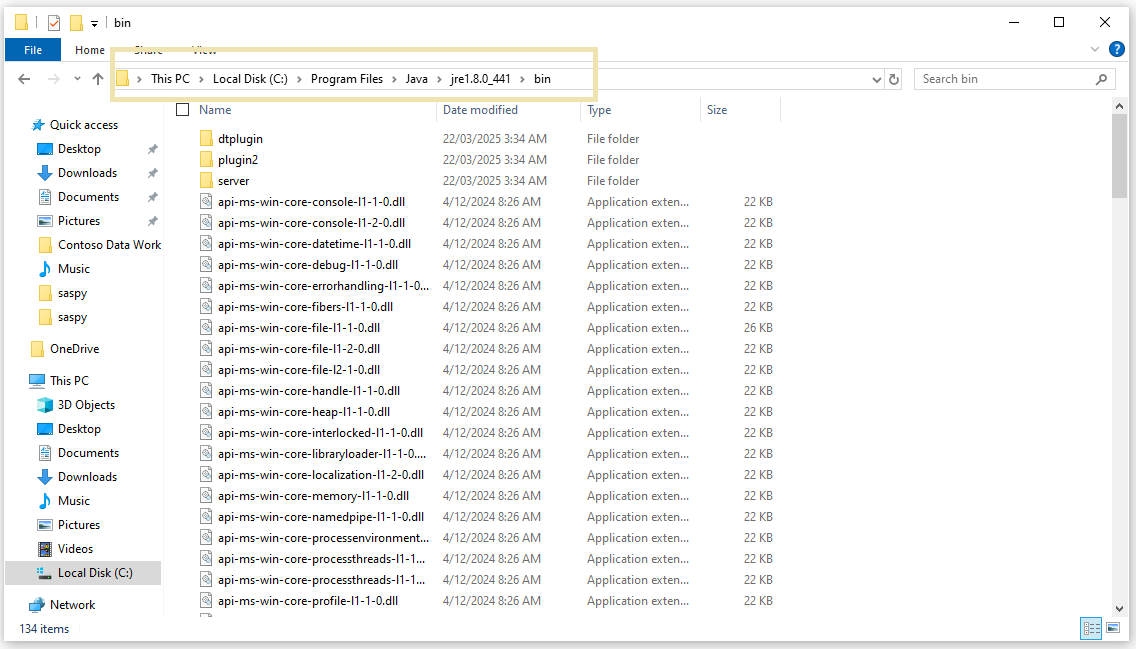

### 5. Finding and editing SAS Configuration file for saspy

This part drove me **crazy**. I will be helpful. Whenever, PIP installs a package, folders are created in multiple locations. For example, installing saspy created following folders. The trick is to find the correct folder.

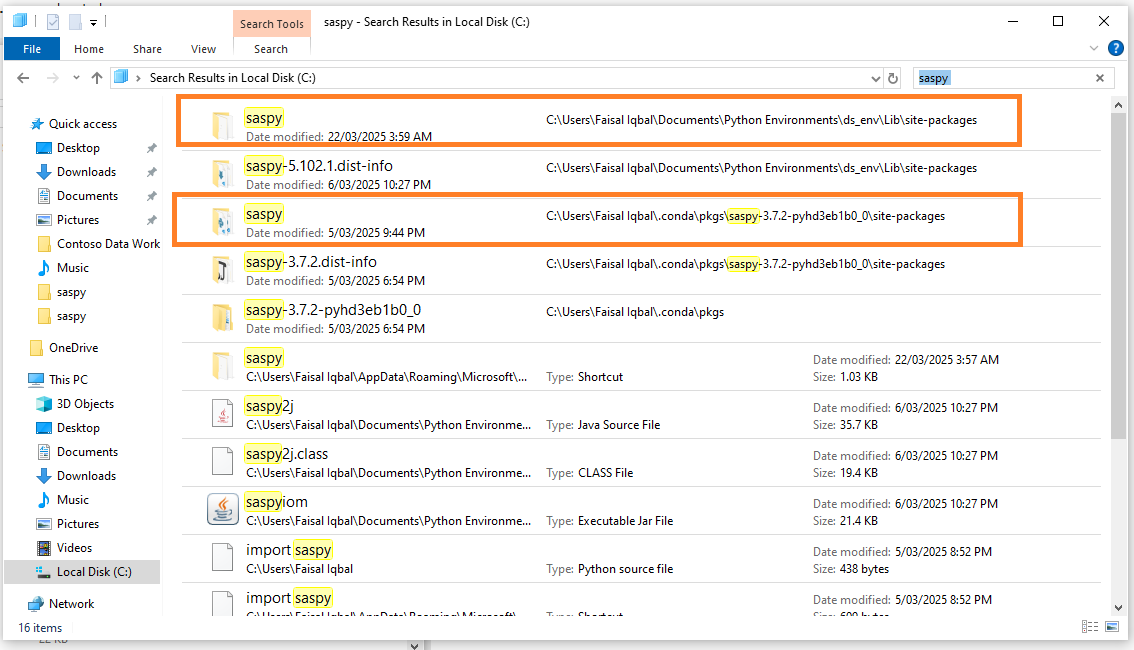

To find the correct folder, I ran the following commands.

1. Activated Python 
2. Imported saspy
3. Ran the saspy module

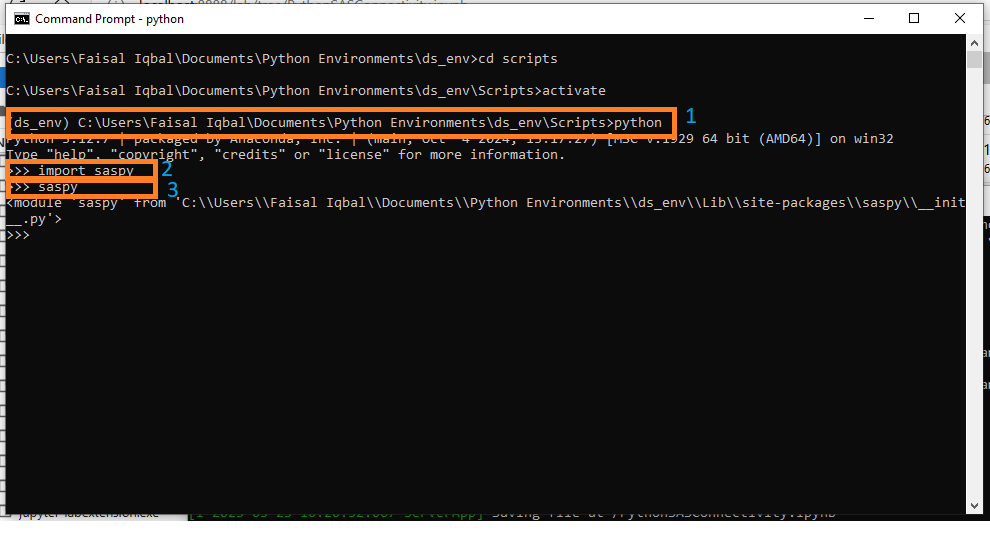

The last line of the output shows the location of the configuration file. The following screen shot shows the file I was interested in. Copy the **sascfg.py** and paste it as **sascfg_personal.py**

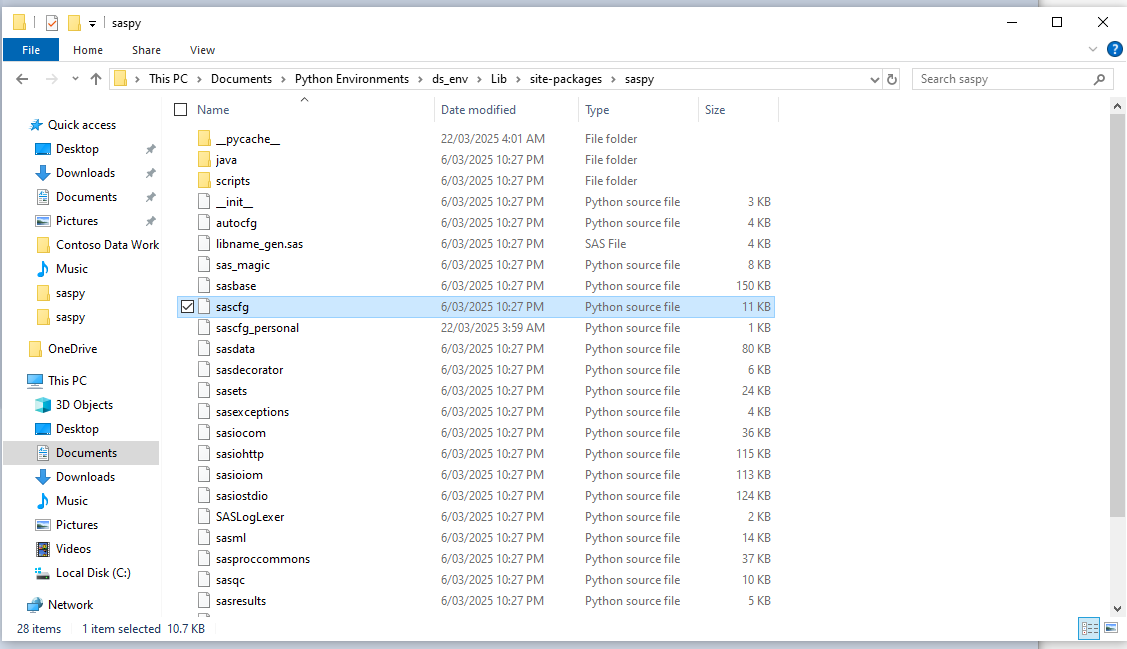

**sascfg_personal.py** is the file that is of my concern. The original file has lots of configuration settings. However, I found out that I needed to create an entire set of configuration settings. I am attaching the snapshot of the file.

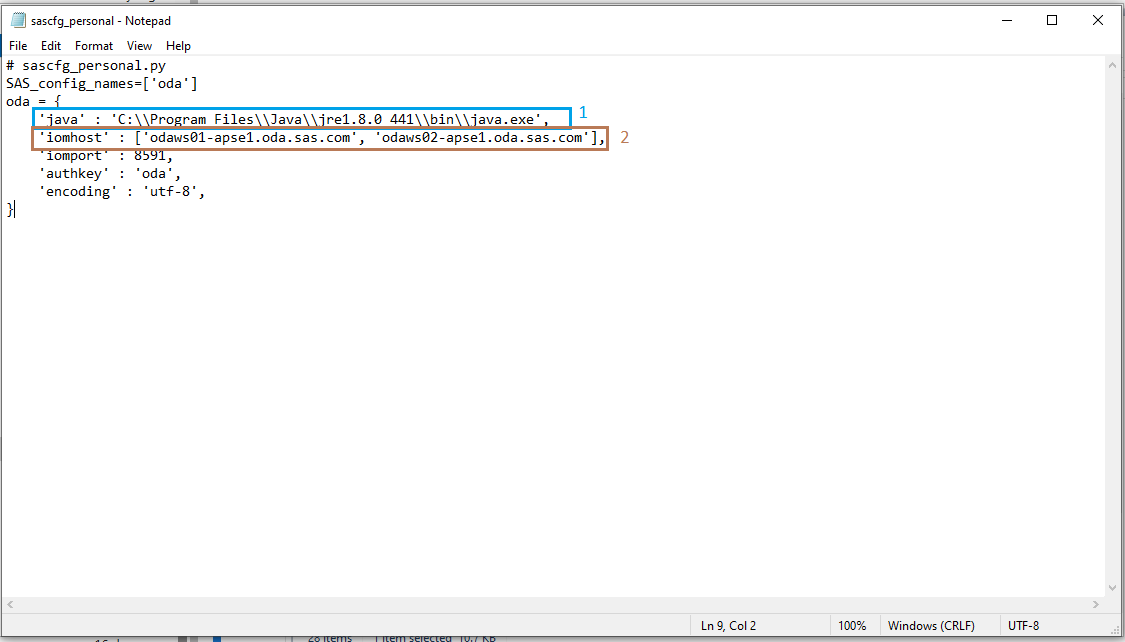

Note the following points:
1. The java path has double back slashes
2. The IOMHosts list: Integrated Object Model is a list of servers that are SAS specific and geography specific. Since I am workng in Australia, I picked up these servers. Other serevrs list can be found in original **saspycfg.py**

### 6. Creating the file for authentication my access

Note that the above file does not have any login information. The next step is to create this info file. Since I am working on Windows 10 platform I created a file **_authinfo**. Note that there is no extension in the file. I created the file in Notepad and saved the file in my personal directory.

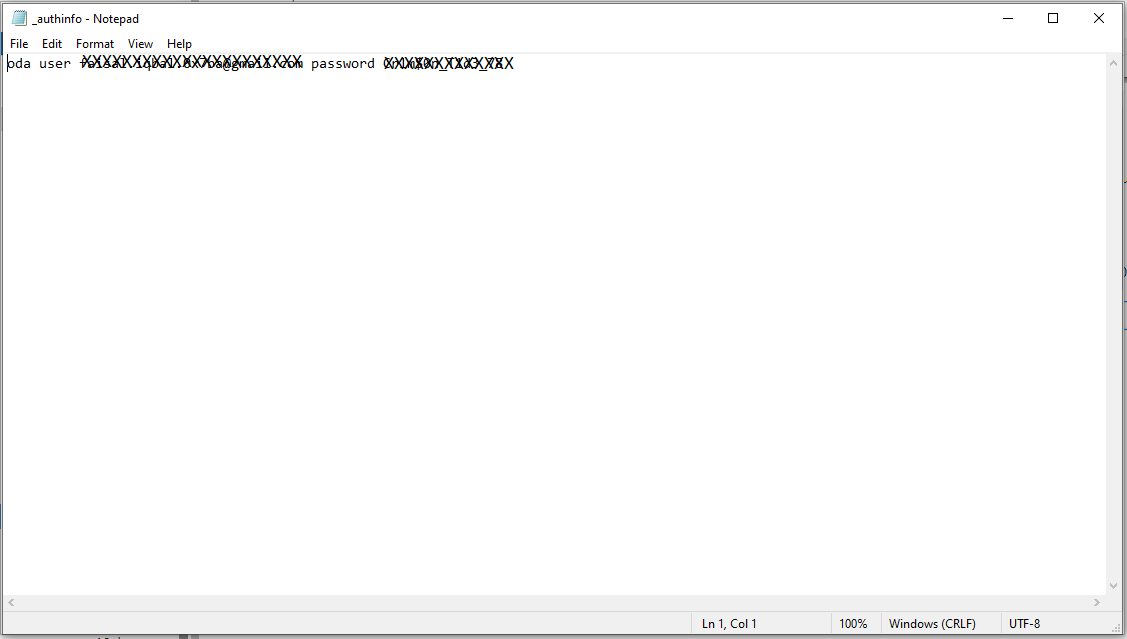

The user should follow the email address which is used to connect the **SAS Ondemand for Academics**. The password will be the one that is associated with **SAS Ondemand for Academics**. Also note that the file should be UTF-8 encoding. This **_authinfo** file is located in my personal directory. 

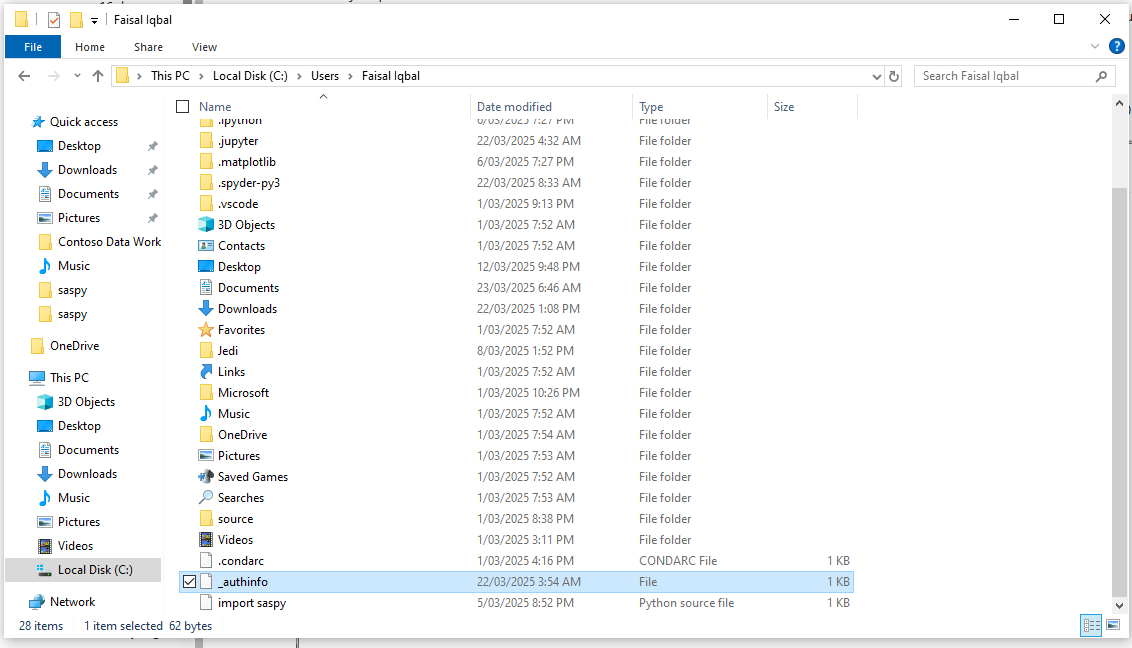

## The Actual Program

## The data

The data are from a sample of individuals who were asked to provide information about themselves and their cars. The questions included:
1. origins of their vehicles (American, Japanese, European)
2. size of their vehicles (small, medium, large)
3. type of the vehicle (family, sporty, work)
4. type of home ownership (own, rent)
5. gender of the respondant (male, female)
6. income streams (1 income, 2 incomes)
7. family status (single and living with children, married and living with children, single, married)


Let us start.
I am going to read a a text file which is originally in a very very weird format.

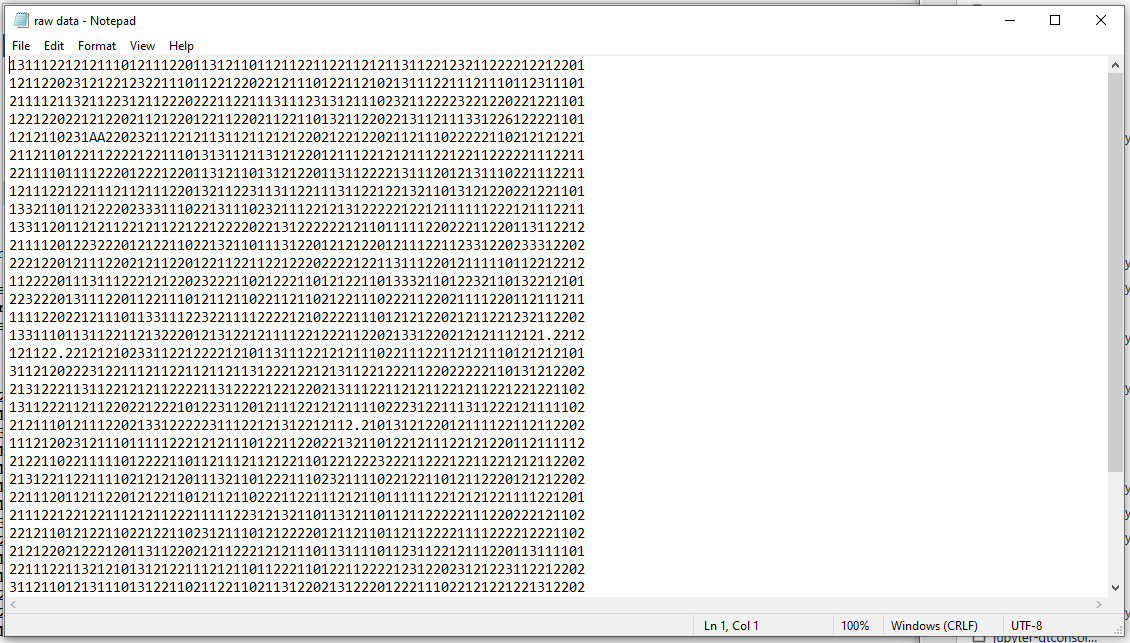

There are 8 responses in each row from 9 respondents. I am going to use Python to read the file and seperate responses by each respondent.

## Cleaning the data

In [1]:

def split_text_and_write_no_newline(input_file, output_file, chunk_size=8):
    """
    Reads text from an input file, inserts newlines after every 'chunk_size' characters,
    excluding existing newline characters, and writes the modified text to an output file.

    Args:
        input_file (str): Path to the input text file.
        output_file (str): Path to the output text file.
        chunk_size (int): Number of characters per line. Defaults to 8.
    """
    try:
        with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
            text = infile.read()
            text = text.replace('\n', '') # Remove all newlines before processing
            modified_text = ""
            for i in range(0, len(text), chunk_size):
                modified_text += text[i:i + chunk_size] + "\n"

            outfile.write(modified_text)

        print(f"Text from '{input_file}' processed and written to '{output_file}'.")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

input_filename = "C:\\Users\\Faisal Iqbal\\Documents\\raw data.txt" 
output_filename = "C:\\Users\\Faisal Iqbal\\Documents\\output.txt" 

split_text_and_write_no_newline(input_filename, output_filename)

Text from 'C:\Users\Faisal Iqbal\Documents\raw data.txt' processed and written to 'C:\Users\Faisal Iqbal\Documents\output.txt'.


My plan is to push the output file to SAS so that I can properly FORMAT the data. Easiest way is to create a Pandas dataframe and then let SAS do its work.

### Importing libraries

In [2]:
import pandas as pd
import saspy
import io

### Reading the output.txt file in Pandas

In [3]:
import pandas as pd
import io

def read_fixed_width_to_dataframe(file_path_or_string):
    """
    Reads a text file or string with fixed-width lines (8 characters) into a pandas DataFrame.

    Args:
        file_path_or_string: Path to the text file or a string containing the data.

    Returns:
        pandas DataFrame with 8 columns, each representing a character.
    """
    try:
        if isinstance(file_path_or_string, str) and '\n' in file_path_or_string: #Handle string input
            lines = file_path_or_string.splitlines()

        else: # Handle file input
            with open(file_path_or_string, 'r') as f:
                lines = f.readlines()

        data = []
        for line in lines:
            line = line.strip()  # Remove leading/trailing whitespace
            if len(line) == 8:
                data.append(list(line))
            elif len(line) > 0: # handle lines that are not empty but not of length 8.
                print(f"Warning: line '{line}' is not of length 8. Skipping.")

        df = pd.DataFrame(data, columns=[f'col_{i}' for i in range(1, 9)])
        return df

    except FileNotFoundError:
        print(f"Error: File '{file_path_or_string}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage with a file path:
# file_path = 'my_data.txt'  # Replace with your file path
# Create a test file
# with open(file_path, "w") as f:
#    f.write("ABCDEFGH\n")
#    f.write("12345678\n")
#    f.write("QWERTYUI\n")
#    f.write("short\n") # test short line
#    f.write("long line\n") # test long line
#    f.write("\n") # test blank line
df_from_file = read_fixed_width_to_dataframe(output_filename)
if df_from_file is not None:
    print(df_from_file)

# Example usage with a string:
# data_string = "ABCDEFGH\n12345678\nQWERTYUI"
# df_from_string = read_fixed_width_to_dataframe(data_string)
# if df_from_string is not None:
#    print(df_from_string)

    col_1 col_2 col_3 col_4 col_5 col_6 col_7 col_8
0       1     3     1     1     1     2     2     1
1       2     1     2     1     1     1     0     1
2       2     1     1     1     2     2     0     1
3       1     3     1     2     1     1     0     1
4       1     2     1     1     2     2     1     1
..    ...   ...   ...   ...   ...   ...   ...   ...
334     1     2     1     1     1     2     2     1
335     3     1     2     2     1     1     0     1
336     1     2     1     2     1     1     0     2
337     2     2     1     2     2     2     0     2
338     1     2     1     2     1     1     0     1

[339 rows x 8 columns]


### Renaming the columns of the dataframe

In [4]:
df_from_file.columns = ['Origin_c', 'Size_c',  'Type_c',  'Home_c',  'Income_c',  'Marital_c',  'Kids_c',  'Sex_c']
print(df_from_file.head())
print("No of rows" + str(df_from_file.shape[0]))

  Origin_c Size_c Type_c Home_c Income_c Marital_c Kids_c Sex_c
0        1      3      1      1        1         2      2     1
1        2      1      2      1        1         1      0     1
2        2      1      1      1        2         2      0     1
3        1      3      1      2        1         1      0     1
4        1      2      1      1        2         2      1     1
No of rows339


### Moving the dataset to SAS and doing something magical - **Multiple Correspondence Analysis**

I will be providing all the step by step break down at the end. For the time being, it will be interesting to know that we are dealing with only and only Categorical variables and the analysis was to look at relationships between all the categorical variables. Since there are multiple categorical variables, i will be performing **Multiple Correspondence Analysis**.
While connecting to SAS through Python, one major restriction is that SAS session settings are lost when hopping between cells. For this reason, I will have to run the whole analysis in one single go.

Using SAS Config named: oda
SAS Connection established. Subprocess id is 17568




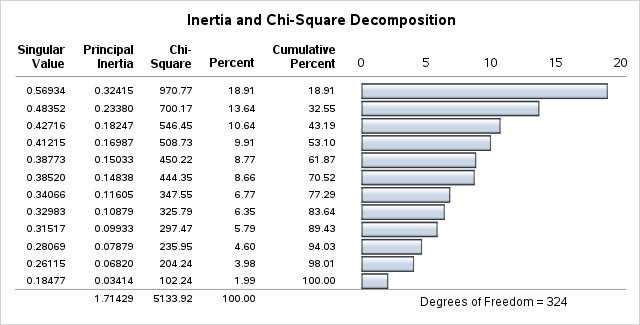
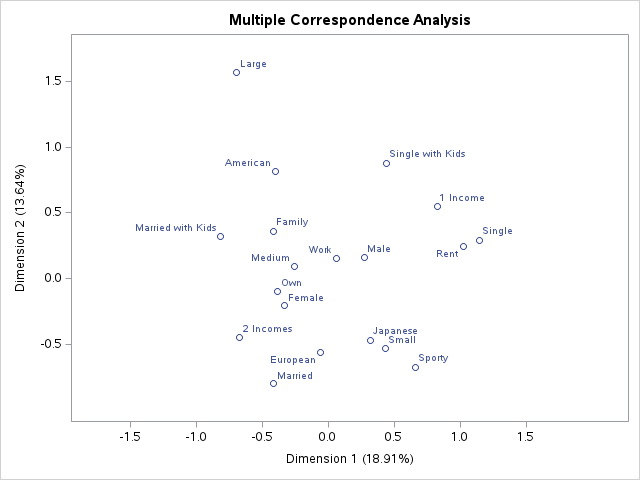

In [5]:
try:
    sas = saspy.SASsession()
    sas.df2sd(df_from_file, 'sasdf', libref = 'work')
    sas.submitLST("""
    proc format;
      value Origin  1 = 'American' 2 = 'Japanese' 3 = 'European';
      value Size    1 = 'Small'    2 = 'Medium'   3 = 'Large';
      value Type    1 = 'Family'   2 = 'Sporty'   3 = 'Work';
      value Home    1 = 'Own'      2 = 'Rent';
      value Sex     1 = 'Male'     2 = 'Female';
      value Income  1 = '1 Income' 2 = '2 Incomes';
      value Marital 1 = 'Single with Kids' 2 = 'Married with Kids'
                    3 = 'Single'           4 = 'Married';
      run;
    data Cars;
      set sasdf;
      missing a;

      origin = input(origin_c, 8.); 
      size = input(size_c, 8.); 
      type = input(type_c, 8.);
      home = input(home_c, 8.); 
      sex = input(sex_c, 8.);
      income = input(income_c, 8.);
      kids = input(kids_c, 8.);
      marital = input(marital_c, 8.);
      marital = 2 * (kids le 0) + marital;

      keep Origin Size Type Home Income Marital Sex;

      format Origin Origin. Size Size. Type Type. Home Home.
             Sex Sex. Income Income. Marital Marital.;
      output;
    run;
    proc datasets library = work;
        contents data = cars;
    run; quit;
    proc print data = work.cars ( obs = 5 ); run;

    proc corresp mca observed data=Cars outc=corrs_vars outf=corrs_freq;
      tables Origin Size Type Income Home Marital Sex;
    run;

    """, method='listorlog'
    )
except:
    print("SAS Session could not be established")

### Explaining the output

#### The scatter plot

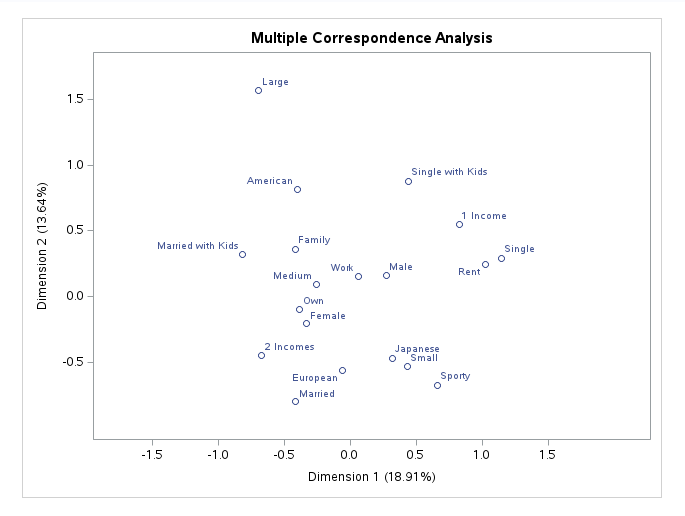

**Fig 1: Multiple Correspondence Analysis Plot**

Lets breakdown this plot in ***Fig 1***. **Dimensions** are latent (hidden) variables that capture the relationships in the categorical variables. In the above screenshot, there are 2 dimensions or axes. Dimension 1 is explaining 18.91% of **Inertia**. 

#### Inertias

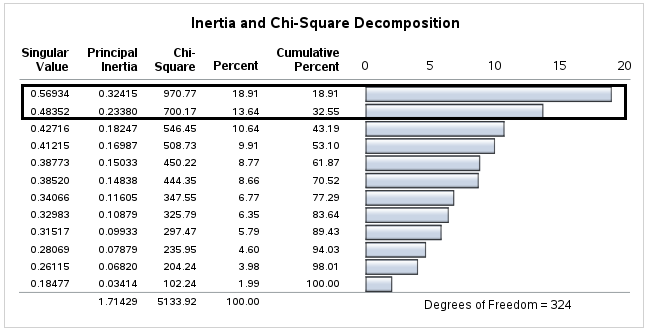

**Fig 2: Inertia and Chi-Square Scores**

Note that the percent values in the highlighted rows. They represent the numbers pasted along the labels in the ***Fig 1***. So Dimension 1 has an inertial value of 18.91% and both dimensions have a total inertial value of 32.55%. **Inertia**, in simple terms, explain how much variation within the data is explained by each dimension. The above ***Fig 2*** shows that the two diemensions explain 32.55% of the variation in the data in assumption that there would be no inertia if there was no correlation between the categorical variable.

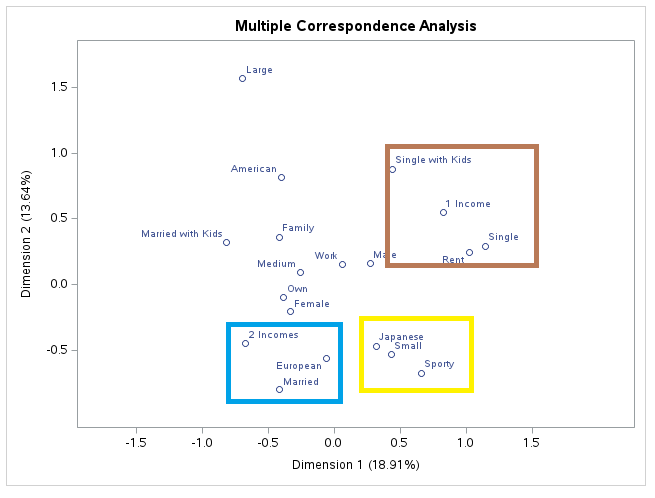

Diving deeply into the scattter plot, it should be noted that MCA plot should be read with the available data at hand. The red box, clearly shows that Single or Single with kids is closely associated with 1-income households or people renting their residences. Japanese cars are small and sporty. The points in blue box can be interpredted to have people that will have 2-incomes, are married and own their house. Note that marker for Own is not in the box. Marketing may require further analysis if this phenomenon is associated with European cars only or with American cars. Note that American cars are more aligned with dimension 2. Dimension 2 can be interpreted with those abservations that represent Large, Americam working families. 

## References

SAS Multiple Correspondence Analysis https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_corresp_sect026.htm

SAS in Jupyter Notebook https://www.9to5sas.com/sas-in-jupyter-notebook/